# Non-linear Breit-Wheeler pair creation

In [1]:
import math as m
import numpy as np

electron_mass = 9.10938356e-31
elementary_charge = 1.6021766208e-19
speed_of_light = 299792458
reduced_plank = 1.054571800e-34
vacuum_permittivity =  8.854187817e-12
fine_structure_constant =  0.0072973525664

classical_elec_radius = (1./4./np.pi/vacuum_permittivity)*( elementary_charge**2 / (electron_mass * speed_of_light**2))

lambda_laser = 1.0e-6

schwinger_field_SI = electron_mass**2 * speed_of_light**3 / (reduced_plank*elementary_charge)

schwinger_field_code_units = electron_mass*speed_of_light*lambda_laser/(2.0*reduced_plank*m.pi)

conversion_of_rate_from_code_to_SI = (2.0 * m.pi * speed_of_light)/lambda_laser

conversion_of_rate_from_SI_to_code = 1.0/conversion_of_rate_from_code_to_SI

field_reference_PIC = 2.0 * np.pi * electron_mass * speed_of_light * speed_of_light / (elementary_charge*lambda_laser)

def calc_chi_gamma(p, E, B):
    gamma_phot = np.linalg.norm(p)  
    c = p/gamma_phot  
    loc_field = gamma_phot * np.linalg.norm( E - np.dot(c,E)*c + np.cross(c,B))     
    return loc_field/schwinger_field_code_units

import scipy.special as spe
import scipy.integrate as integ

def inner(x):
    return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0] 

inner = np.vectorize(inner)

def X(chi_phot, chi_ele):
    if (chi_phot > chi_ele and chi_ele != 0):
        return np.power(chi_phot/(chi_ele*(chi_phot-chi_ele)), 2./3.)        
    else:
        return 1.0e30

X = np.vectorize(X)

def T(chi_phot):
    coeff = 1./(np.pi * np.sqrt(3.) * chi_phot * chi_phot)
    return integ.quad(lambda chi_ele: 
                      coeff*(inner(X(chi_phot, chi_ele)) - 
                      (2.0 - chi_phot*np.power(X(chi_phot, chi_ele), 3./2.))*spe.kv(2./3., 2./3. *X(chi_phot, chi_ele)**(3./2.)) )
                      , 0, chi_phot)[0] 
T = np.vectorize(T)
    
def dNBW_dt(chi_phot, e_phot):
    val = ((electron_mass*(speed_of_light)**2)*fine_structure_constant/reduced_plank)*(chi_phot/e_phot)*T(chi_phot)
    return val

px = np.logspace(-1, 8.0, num=100, base=10)

def ff(px):
    return dNBW_dt(calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0])), px)

ff = np.vectorize(ff)

def cc(px):
    return calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0]))

cc = np.vectorize(cc)


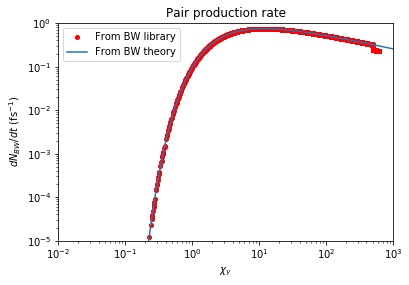

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.loadtxt('bw_rate.dat', delimiter=' ', unpack=True)
plt.loglog(x,y, 'ro', label='From BW library', markersize=4)
plt.loglog(cc(px), ff(px)*1e-15, label='From BW theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{BW}/dt$ (fs$^{-1}$)')
plt.title('Pair production rate')
plt.legend()
plt.ylim(1e-5, 1)
plt.xlim(1e-2,1e3)
plt.show()

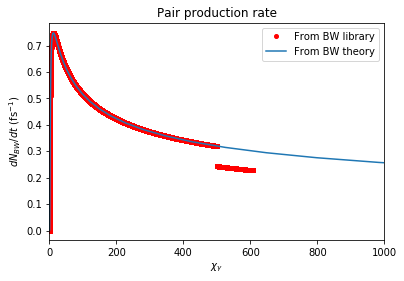

In [5]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.loadtxt('bw_rate.dat', delimiter=' ', unpack=True)
plt.plot(x,y, 'ro', label='From BW library', markersize=4)
plt.plot(cc(px), ff(px)*1e-15, label='From BW theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{BW}/dt$ (fs$^{-1}$)')
plt.title('Pair production rate')
plt.legend()
plt.xlim(1e-2,1e3)
plt.show()

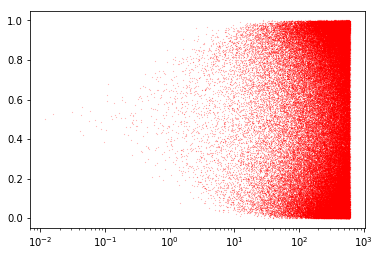

In [6]:
x, ye = np.loadtxt('bw_pairs.dat', delimiter=' ', unpack=True, usecols=(0,1))
pairs = zip(x, ye)
sel = [pps for pps in pairs if pps[1] <= 1.0]
x,ye = zip(*sel)
xedges = np.linspace(0, 600.0, num=100)
yedges = np.linspace(0.0, 1.0, num=20)
H, xedges, yedges = np.histogram2d(x, ye, bins=(xedges, yedges))
H = H.T
XX, YY = np.meshgrid(xedges, yedges)
#plt.pcolormesh(X, Y, H)
plt.semilogx(x,ye,'ro', markersize=0.1)
plt.show()

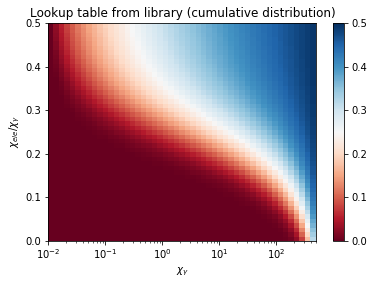

In [7]:
chilen = 50
fraclen = 50
chi, frac, prob = np.loadtxt('cum_prob_tab.dat', delimiter=' ', unpack=True, usecols=(0,1,2))
chi = np.exp(chi)
chi = chi[0::chilen]
frac = frac[0:fraclen]
prob = prob.reshape(chilen, fraclen)
CHI, FRAC = np.meshgrid(chi, frac)
plt.xscale("log")
p = plt.pcolor(CHI, FRAC, prob, cmap=plt.cm.RdBu, vmin=abs(prob).min(), vmax=abs(prob).max())
plt.title("Lookup table from library (cumulative distribution)")
plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$\chi_{ele}/\chi_{\gamma}$ ')
cb = plt.colorbar(p)

In [8]:
def num(chi_phot, chi_part):
    coeff = 1./(np.pi * np.sqrt(3.) * chi_phot * chi_phot)
    return integ.quad(lambda chi_ele: 
                      coeff*(inner(X(chi_phot, chi_ele)) - 
                      (2.0 - chi_phot*np.power(X(chi_phot, chi_ele), 3./2.))*spe.kv(2./3., 2./3. *X(chi_phot, chi_ele)**(3./2.)) )
                      , 0, chi_part)[0] 

num = np.vectorize(num)

def P(chi_phot, frac):
    print(str(chi_phot) + " " + str(frac))
    return num(chi_phot, frac*chi_phot)/T(chi_phot)


pairs = zip(CHI.ravel(), FRAC.ravel())


PP = [P(pa[0], pa[1]) for pa in pairs]

PP = np.reshape(PP, (chilen, fraclen)).T


p = plt.pcolor(CHI, FRAC, P(CHI, FRAC), cmap=plt.cm.RdBu, vmin=abs(prob).min(), vmax=abs(prob).max())
cb = plt.colorbar(p)


0.010000001859881084 0.0
0.012470866935682721 0.0
0.01555224932021702 0.0
0.019395193526025062 0.0
0.024187483266903093 0.0
0.030163882922936543 0.0
0.0376169700232363 0.0
0.0469116140433322 0.0
0.05850283876641773 0.0
0.07295882777686079 0.0
0.0909859663765545 0.0
0.1134673668660704 0.0
0.14150361705491574 0.0
0.17646724510015666 0.0
0.22007211299479584 0.0
0.27444895269702146 0.0
0.342261573315621 0.0
0.4268297744163901 0.0
0.5322946976814721 0.0
0.6638188387096964 0.0
0.8278411424071341 0.0
1.0323912361357368 0.0
1.287482807411758 0.0
1.6056055899061445 0.0
2.0023329985433986 0.0
2.4970873683182457 0.0
3.114099420982712 0.0
3.883551228061853 0.0
4.843124159543158 0.0
6.039794571335324 0.0
7.532146040908572 0.0
9.393331287442784 0.0
11.71429627812861 0.0
14.60874029591855 0.0
18.218362244435905 0.0
22.71987290801643 0.0
28.333645913428363 0.0
35.33485957394257 0.0
44.065624998085006 0.0
54.953644358156865 0.0
68.53194589601353 0.0
85.46526191573682 0.0
106.58363690539166 0.0
132.9190

KeyboardInterrupt: 

Text(0, 0.5, '$\\chi_{ele}/\\chi_{\\gamma}$ ')

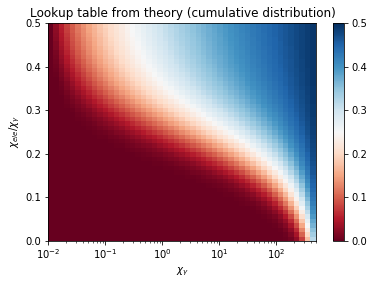

In [141]:
p = plt.pcolor(CHI, FRAC, PP, cmap=plt.cm.RdBu, vmin=abs(prob).min(), vmax=abs(prob).max())
cb = plt.colorbar(p)
plt.xscale("log")
plt.title("Lookup table from theory (cumulative distribution)")
plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$\chi_{ele}/\chi_{\gamma}$ ')

(array([   3.,    5.,   13.,   32.,   71.,   97.,  166.,  236.,  293.,
         400.,  457.,  526.,  676.,  761.,  842., 1012., 1099., 1175.,
        1273., 1375., 1451., 1565., 1536., 1660., 1721., 1799., 1876.,
        1896., 1884., 1982., 2101., 2124., 2044., 2149., 2198., 2216.,
        2143., 2252., 2170., 2258., 2230., 2250., 2273., 2237., 2182.,
        2148., 2152., 2120., 2107., 1959., 2043., 2054., 1920., 1930.,
        1848., 1777., 1674., 1551., 1557., 1455., 1340., 1283., 1185.,
        1083., 1017.,  915.,  817.,  713.,  605.,  506.,  431.,  348.,
         274.,  180.,  144.,   67.,   47.,   28.,   13.]),
 array([  92.8201,  109.1582,  125.4963,  141.8344,  158.1725,  174.5106,
         190.8487,  207.1868,  223.5249,  239.863 ,  256.2011,  272.5392,
         288.8773,  305.2154,  321.5535,  337.8916,  354.2297,  370.5678,
         386.9059,  403.244 ,  419.5821,  435.9202,  452.2583,  468.5964,
         484.9345,  501.2726,  517.6107,  533.9488,  550.2869,  566.625 ,
   

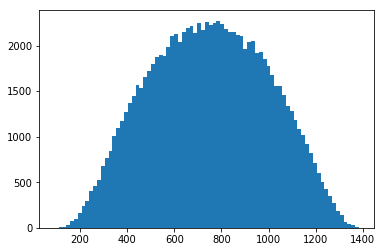

In [9]:
g_ele, g_pos = np.loadtxt('smicheck.dat', delimiter=' ', unpack=True)
plt.hist(g_ele, bins='auto')